In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 1. Load datas

In [2]:
# set paths
sp_data_folder = '/home/jsw/BI/Database/Ravi_Cancer_Cell_2022/10XVisium_2/'
results_folder = './results/'

regression_model_output = 'RegressionModelOutput'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

def read_and_qc(sample_name, path = sp_data_folder):
    r'''Reads the data for one 10X spatial experiment into the anndata object
    It also calculates QC metrics
    
    :param sample_name: Name of the sample
    :param path: path to data
    '''
    adata = sc.read_visium(path + str(sample_name) + '/outs/',
                           count_file = 'filtered_feature_bc_matrix.h5', load_images = True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns = {'gene_ids': 'ENSEMBL'}, inplace = True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns = 'ENSEMBL', inplace = True)
    
    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['MT'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['MT_frac'] = adata[:, adata.var['MT'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs['sapmle'] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs['sample'] + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata


def select_slide(adata, s, s_col = 'sample'):
    r'''Selets the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    '''
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]
    
    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

In [3]:
# read csv and store the first column as list
import pandas as pd
sample_data = pd.read_csv('../spatial_data.csv')
sample_data['combined_id'] = sample_data['ID'] + '_' + sample_data['Tissue_Type'] + '_ST'

In [4]:
slides = []
for combined_id in sample_data['combined_id']:
    slides.append(read_and_qc(combined_id))
    
# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key='sample',
    uns_merge='unique',
    batch_categories=sample_data['combined_id'],
    index_unique=None
)

# replace the sample names with the new names
spatial_to_sample = pd.read_csv('../spatial_to_sample.csv')
for index, row in spatial_to_sample.iterrows():
    old_key = row['old']
    new_key = row['new']
    if old_key in adata.uns['spatial']:
        adata.uns['spatial'][new_key] = adata.uns['spatial'].pop(old_key)
    

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_m

/tmp/ipykernel_11238/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_11238/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_11238/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_11238/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_11238/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial

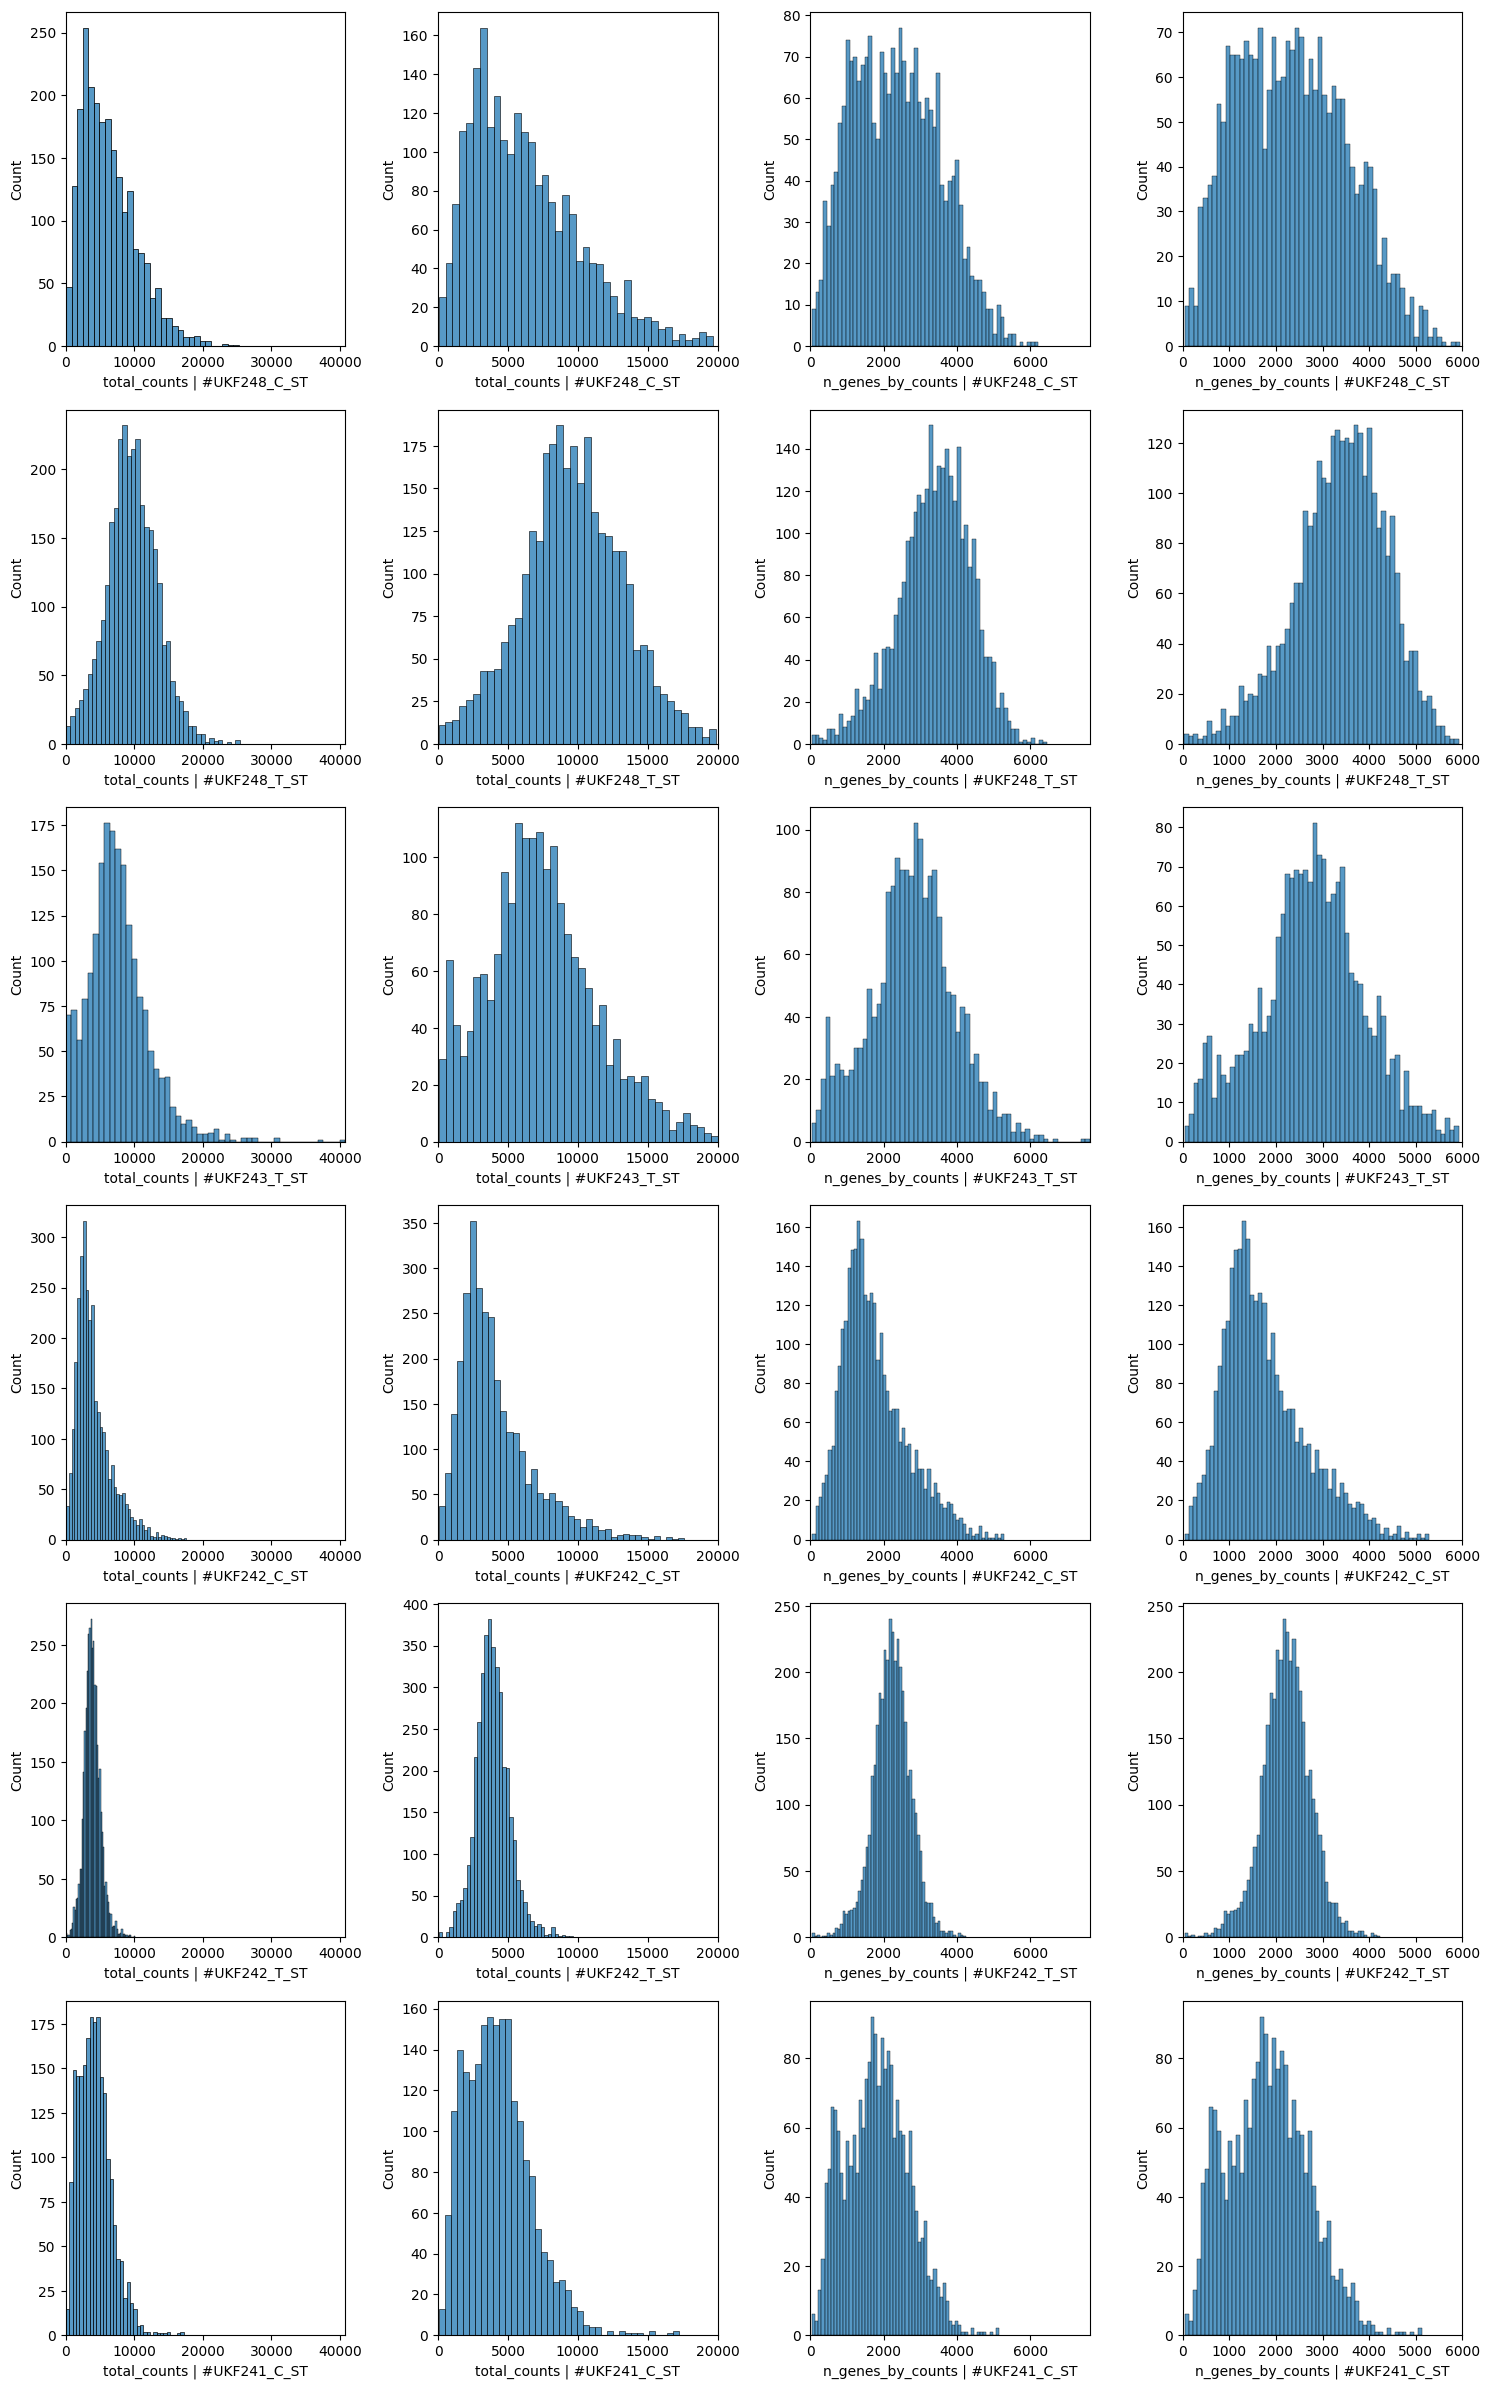

In [5]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    
    sns.histplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

---
# Visualize

In [6]:
# Select slide
slide = select_slide(adata, '#UKF243_T_ST')

/tmp/ipykernel_11238/632334807.py:51: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}


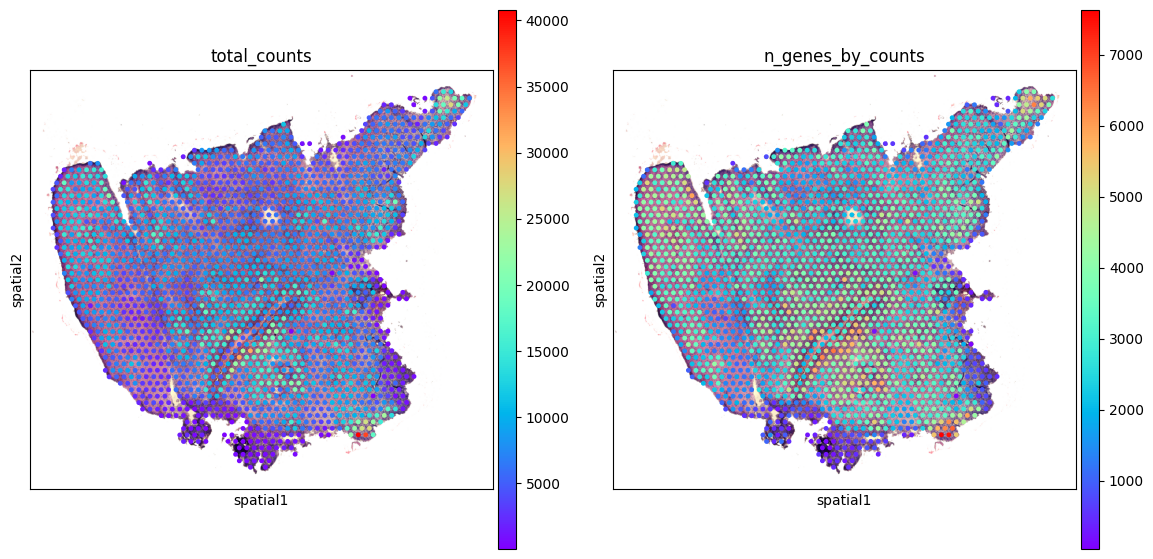

In [7]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(
        slide,
        img_key = "hires",
        cmap='rainbow',
        library_id=list(slide.uns['spatial'].keys())[0],
        color=['total_counts', 'n_genes_by_counts'],
        size=1,
        gene_symbols='SYMBOL',
        show=False,
        return_fig=True
    )

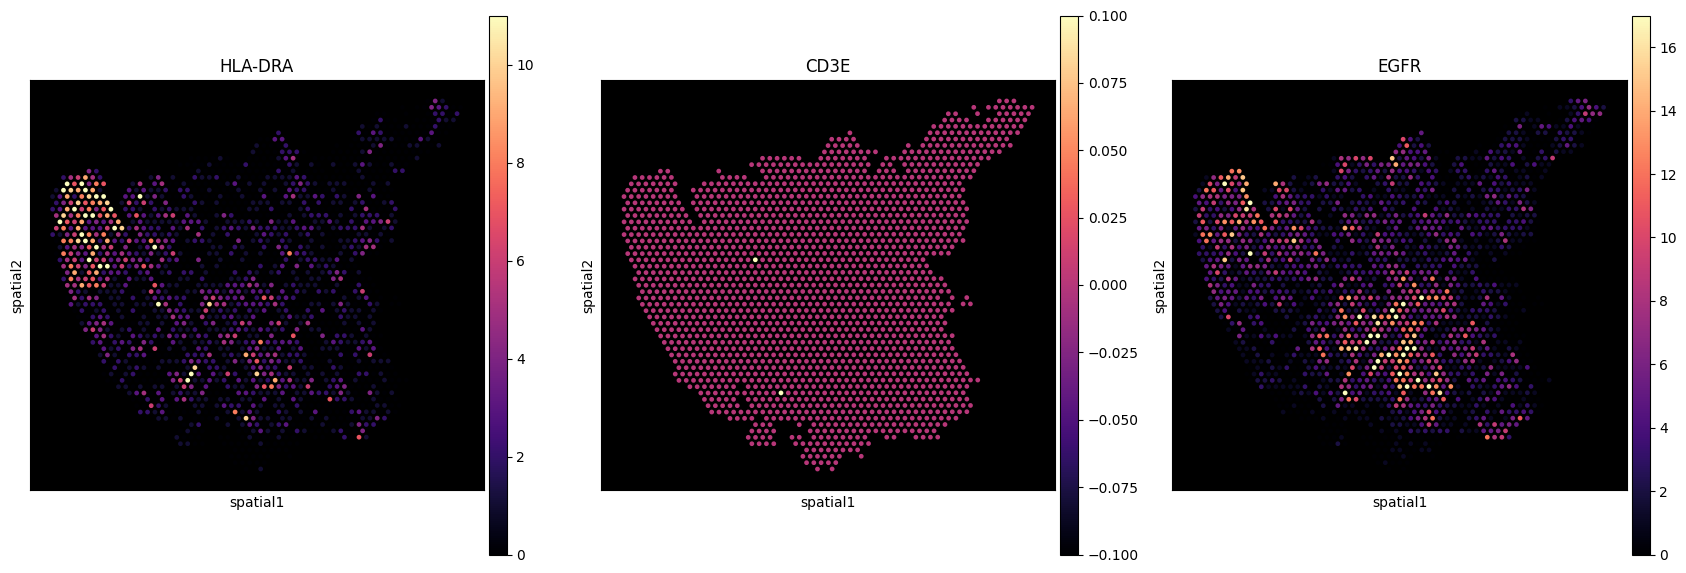

In [8]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(
        slide,
        color=["HLA-DRA", "CD3E", "EGFR"],
        img_key=None,
        size=1,
        vmin=0,
        cmap='magma',
        vmax='p99.0',
        gene_symbols='SYMBOL'
    )

---
# cell2location

In [9]:
inf_aver = pd.read_csv('../data/inf_aver.csv', index_col = 0)

In [10]:
import cell2location

/home/jsw/jswenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-18 21:14:46.714115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 21:14:46.744476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 21:14:46.753978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 21:14:47.226925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

In [11]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata.var_names, inf_aver.index)
adata = adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(
    adata = adata,
    batch_key = 'sample'
)

In [12]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata,
    cell_state_df = inf_aver,
    N_cells_per_location = 30,
    detection_alpha = 20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   6   │
│         n_cells          │ 16316 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 22425 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ #UKF248_C_ST │          0          │
│                     │ #UKF248_T_ST │          1          │
│                     │ #UKF243_T_ST │          2          │
│                     │ #UKF242_C_ST │          3          │
│                     │ #UKF242_T_ST │          4          │
│                     │ #UKF241_C_ST │          5          │
└─────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [13]:
import torch

In [14]:
torch.cuda.empty_cache()

In [15]:
mod.train(
    max_epochs = 2000,
    batch_size = 4096,
    train_size = 1,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to impro

Epoch 2000/2000: 100%|██████████| 2000/2000 [40:04<00:00,  1.20s/it, v_num=1, elbo_train=1.13e+8]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [40:04<00:00,  1.20s/it, v_num=1, elbo_train=1.13e+8]


---

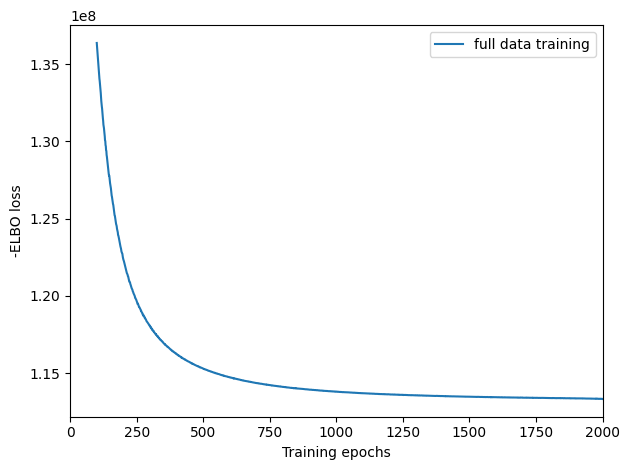

In [16]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['full data training'])

In [18]:
# Export the estimated cell abundance (summary of the posterior distribution)
adata = mod.export_posterior(
    adata,
    sample_kwargs = {
        'num_samples': 1000,
        'batch_size': mod.adata.n_obs
    }
)

Sampling global variables, sample: 100%|██████████| 999/999 [01:08<00:00, 14.60it/s]


In [19]:
# save model
mod.save('run_model', overwrite = True)

In [20]:
# save anndata object with results
adata.write('run_model/sp.h5ad')

In [ ]:
# load adata
# adata = sc.read_h5ad('run_model/sp.h5ad')
# mod = cell2location.models.Cell2location.load('run_model', adata)

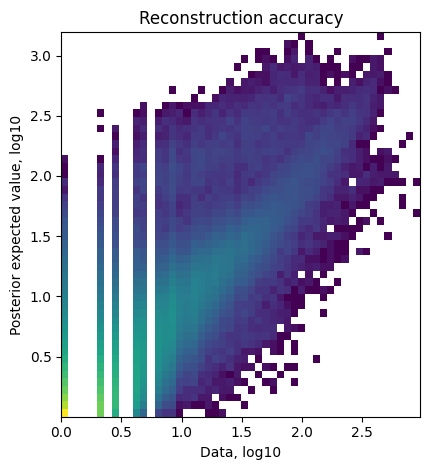

In [21]:
mod.plot_QC()

In [27]:
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf']

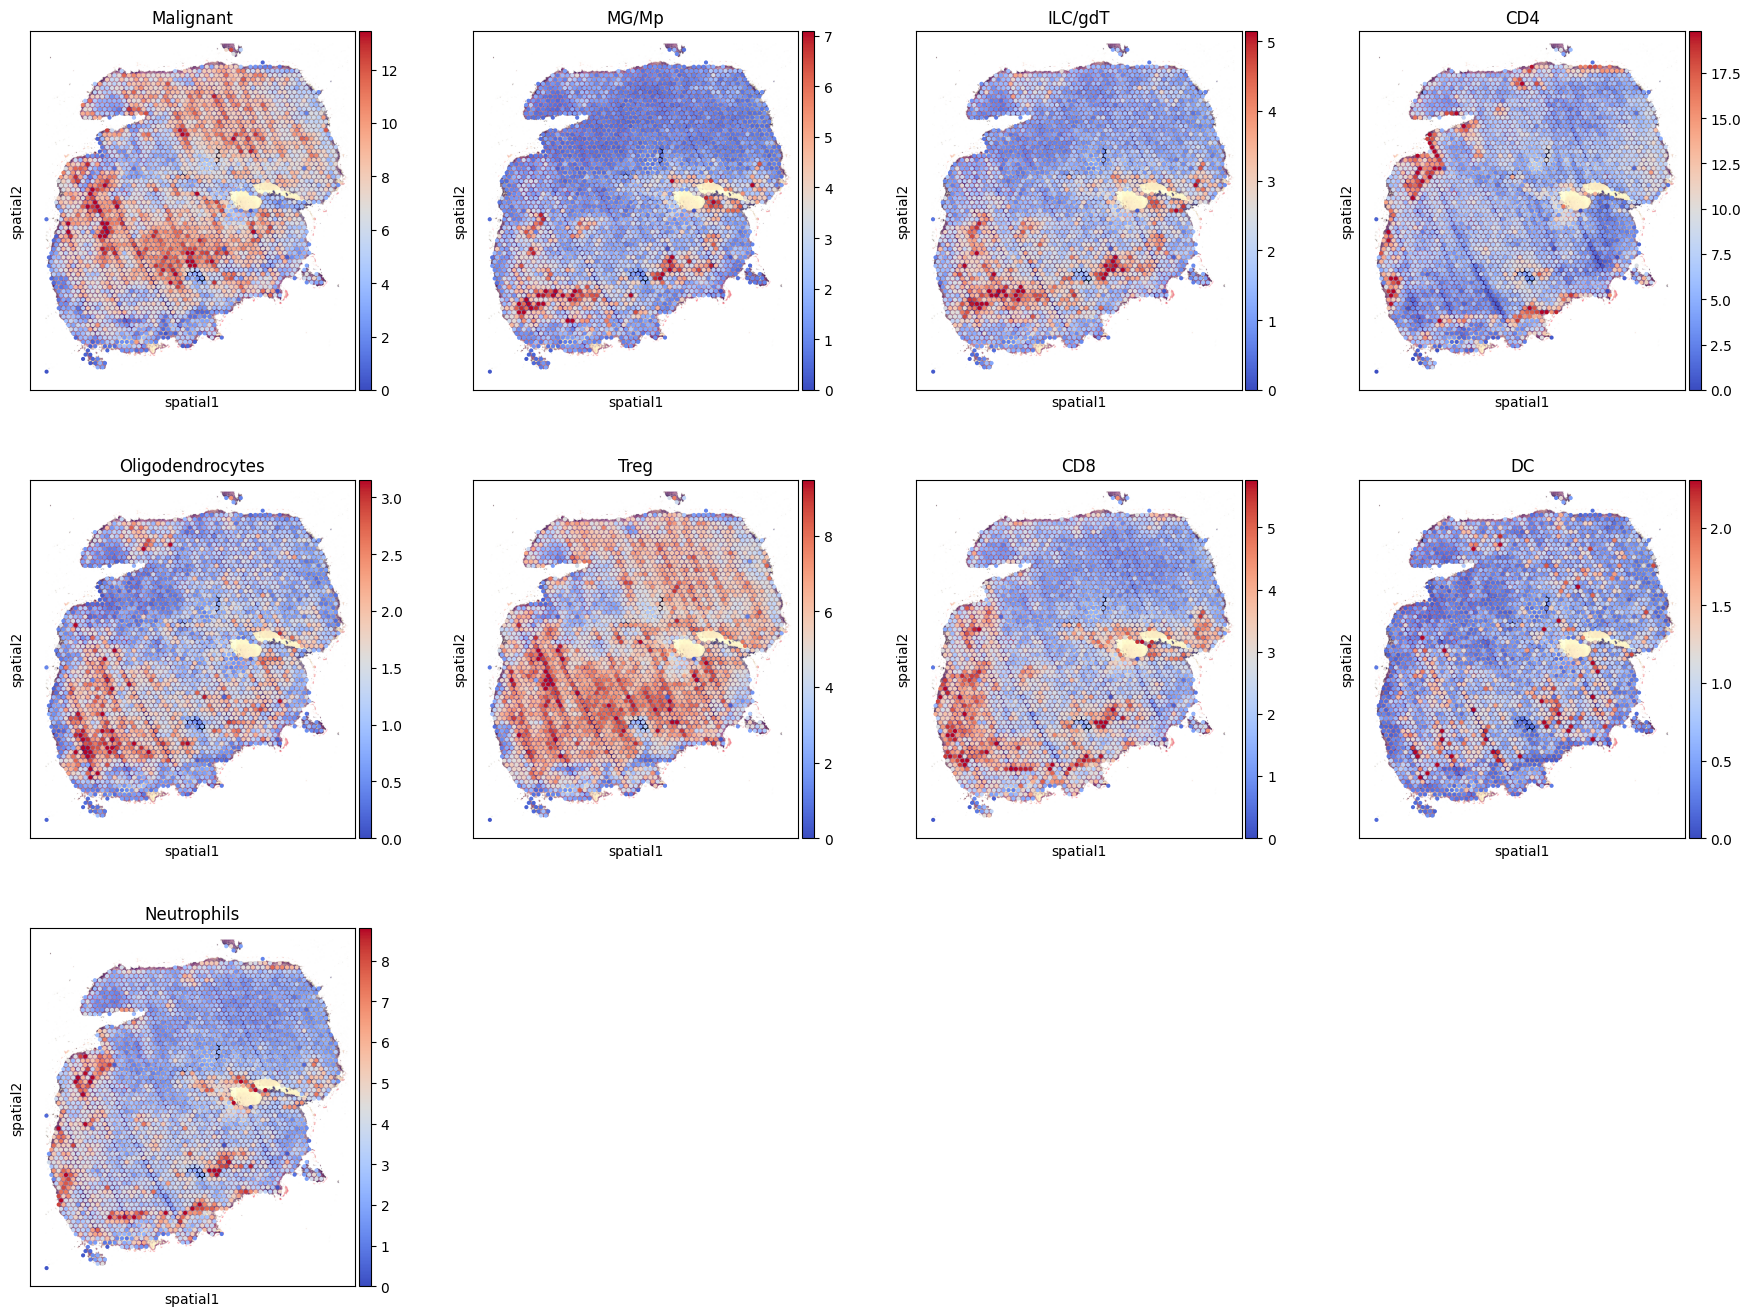

In [56]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata, '#UKF248_T_ST')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='coolwarm',
                  # show first 8 cell types
                  color=['Malignant', 'MG/Mp', 'ILC/gdT', 'CD4', 'Oligodendrocytes',
                         'Treg', 'CD8', 'DC', 'Neutrophils'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0,
                  vmax='p99.2',
                #   vmax = 10
                 )